In [1]:
# 사용할 라이브러리 설치
! pip install tensorflow numpy pandas matplotlib sklearn seaborn opencv-python scikit-image tqdm boto3 sagemaker scikit-learn keras

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
# 사용할 라이브러리 임포트
import os
import boto3
import sagemaker
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow.keras.layers as layers

# 이미지 처리 라이브러리 (open-cv)
import cv2
import random
import matplotlib.pyplot as plt

#데이터 분할 모듈
from sklearn.model_selection import train_test_split

from skimage.transform import resize
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix 

# 이미지 데이터를 수치형 데이터로 변환 
from sklearn.preprocessing import OneHotEncoder

#이미지 텐서 포맷 형식 설정(텐서플로우: channel-last, 씨아노:channel-first)
keras.backend.set_image_data_format('channels_last')

2023-05-11 03:30:02.992493: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 03:30:05.004097: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
#각자의 버킷명과 데이터셋 경로 지정 후 boto3 라이브러리를 통해 s3 접근
bucket_name = 'test-52212874-bucket'
prefix = 'shoes_type/'
s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket_name)

In [4]:
#학습에 필요한 파라미터 선언
test_size = 0.1
dev_size = 0.7
n_H = 102
n_W = 136
epochs = 5
random.seed(6278)

In [5]:
#X= 이미지, Y= 클래스 
X = []
Y = []

#버킷 내 shoe_tpye 폴더 내 객체 접근
for obj in bucket.objects.filter(Prefix=prefix):
    if obj.key == prefix:
        continue

    shoe_type = obj.key.replace(prefix, '').split('/')[0]
    
#이미지를 numpy array로 변환
    img_obj = bucket.Object(obj.key)
    img_data = img_obj.get().get('Body').read()
    img = cv2.imdecode(np.asarray(bytearray(img_data)), cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_array = np.asarray(img)
        
    if img_array.shape != (102,136,3): # Do conditional resizing to save computing power
        img_array = resize(img_array, [n_H,n_W], anti_aliasing=True)
        
    X.append(img_array)
    Y.append(shoe_type)

In [6]:
#X(이미지)와 Y(클래스)를 zip 함수를 통해 묶음
X_Y = list(zip(X,Y)) # Zip images and associated label

#모델 학습시 각 batch에서 연속적인 같은 카테고리 데이터가 나오지 않도록 하기 위한 셔플
random.shuffle(X_Y) # Shuffle
X, Y = zip(*X_Y) # Unzip back into X and Y

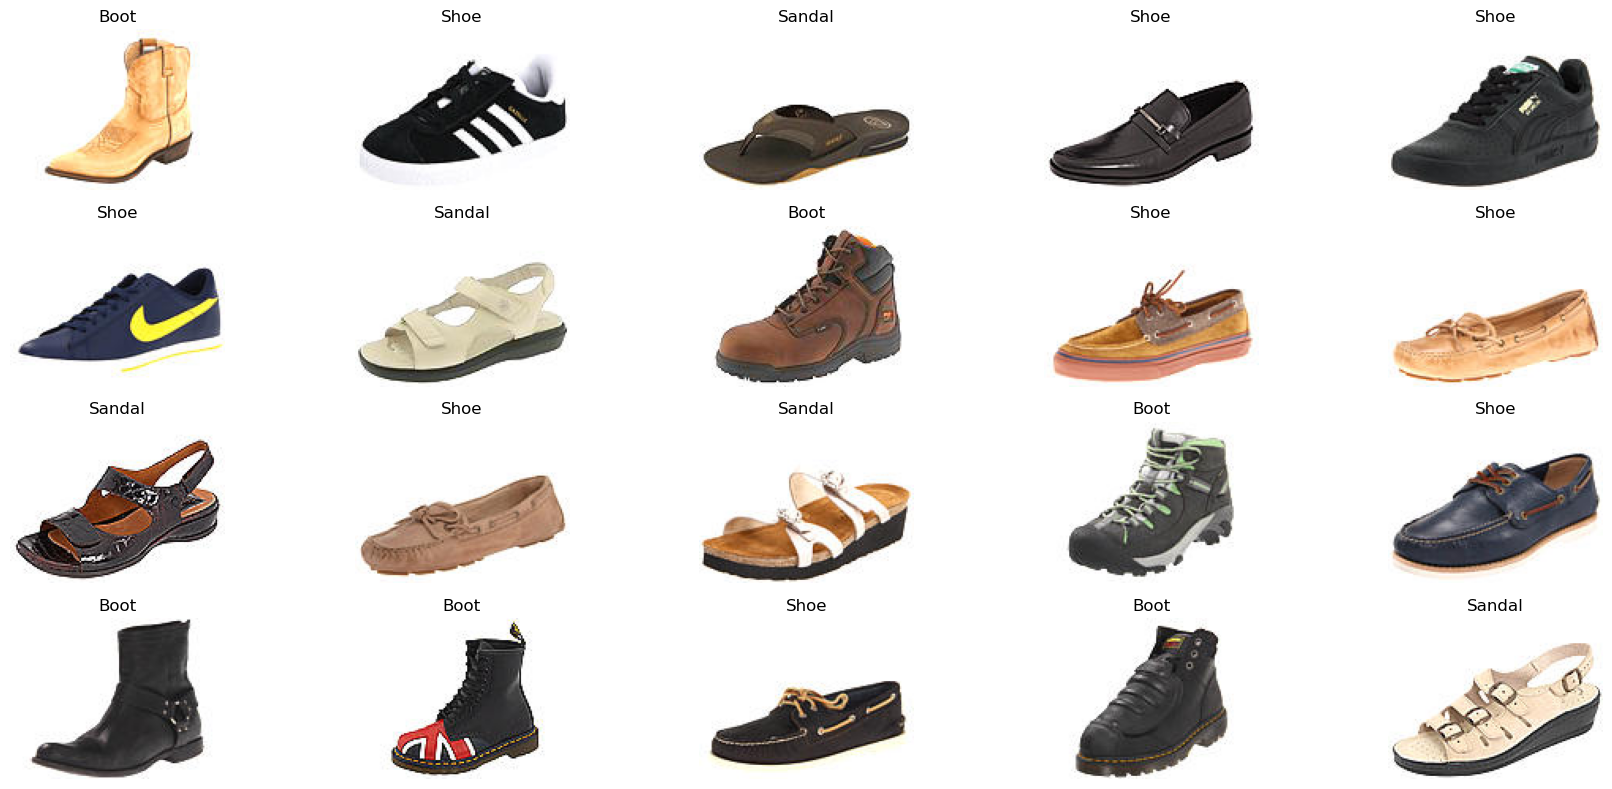

In [7]:
# 샘플 이미지 출력
fig, axs = plt.subplots(4,5, figsize=[18,8])
for i in range(20):
    ax = axs[i//5, i%5]
    ax.imshow(X[i])
    ax.axis('off')
    ax.set_title(Y[i])
    
fig.tight_layout()
fig.show()

In [8]:
# 데이터 분할
num_dev = int(len(X) * dev_size) 
num_test = int(len(X) * test_size)

X_arr = np.asarray(X) / 255
Y_arr = np.asarray(Y).reshape(-1,1)

del X, Y

ohe = OneHotEncoder(categories='auto', sparse=False)
Y_ohe = ohe.fit_transform(Y_arr)

X_train = X_arr[:-(num_test + num_dev)]
X_dev = X_arr[-(num_test + num_dev):-num_test]
X_test = X_arr[-num_test:]

Y_train = Y_ohe[:-(num_test + num_dev)]
Y_dev = Y_ohe[-(num_test + num_dev):-num_test]
Y_test = Y_ohe[-num_test:]

del X_arr, Y_arr, Y_ohe

print("Training X:", X_train.shape)
print("Training Y:", Y_train.shape)
print("Development X:", X_dev.shape)
print("Development Y:", Y_dev.shape)
print("Test X:", X_test.shape)
print("Test Y:", Y_test.shape)

Training X: (600, 102, 136, 3)
Training Y: (600, 3)
Development X: (2100, 102, 136, 3)
Development Y: (2100, 3)
Test X: (300, 102, 136, 3)
Test Y: (300, 3)


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
# 신경망 모델 생성
model = tf.keras.Sequential(name = 'FirstModel')

model = tf.keras.Sequential(name='SingleLayerPerceptron')
model.add(tf.keras.layers.Flatten(input_shape=(n_H, n_W, 3), name='Flatten')) # 입력층
model.add(tf.keras.layers.Dense(units=3, activation='softmax', name='Output')) # 출력층

# 생성될 신경망 모델 구조 출력
model.summary()

2023-05-11 03:31:57.053613: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "SingleLayerPerceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flatten (Flatten)           (None, 41616)             0         
                                                                 
 Output (Dense)              (None, 3)                 124851    
                                                                 
Total params: 124,851
Trainable params: 124,851
Non-trainable params: 0
_________________________________________________________________


In [10]:
# 모델 생성
model.compile(
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train, Y_train, validation_data=(X_dev, Y_dev), epochs=epochs)

Epoch 1/5
13/19 [===================>..........] - ETA: 0s - loss: 35.1548 - accuracy: 0.3293

2023-05-11 03:31:58.509259: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 349574400 exceeds 10% of free system memory.


19/19 [==============================] - 2s 69ms/step - loss: 28.9219 - accuracy: 0.3683 - val_loss: 10.8124 - val_accuracy: 0.5976
Epoch 2/5
19/19 [==============================] - 0s 22ms/step - loss: 13.2022 - accuracy: 0.4850 - val_loss: 1.1194 - val_accuracy: 0.8033
Epoch 3/5
19/19 [==============================] - 0s 27ms/step - loss: 9.9748 - accuracy: 0.5933 - val_loss: 7.5258 - val_accuracy: 0.6271
Epoch 4/5
19/19 [==============================] - 0s 22ms/step - loss: 9.8278 - accuracy: 0.5650 - val_loss: 19.3049 - val_accuracy: 0.6167
Epoch 5/5
19/19 [==============================] - 1s 27ms/step - loss: 8.7422 - accuracy: 0.6350 - val_loss: 15.2351 - val_accuracy: 0.4529


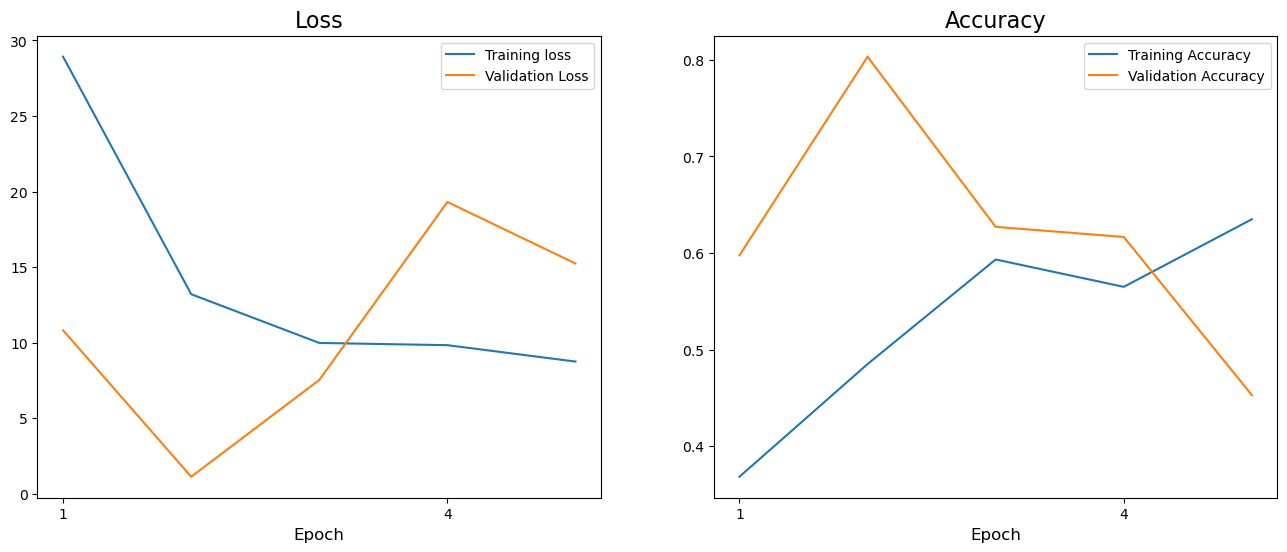

In [11]:
# 학습 결과 시각화
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

ax1.plot(range(1,epochs+1), history.history['loss'], label='Training loss')
ax1.plot(range(1,epochs+1), history.history['val_loss'], label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1,epochs+1,3))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1,epochs+1), history.history['accuracy'], label='Training Accuracy')
ax2.plot(range(1,epochs+1), history.history['val_accuracy'], label='Validation Accuracy')
ax2.legend()
ax2.set_xticks(range(1,epochs+1,3))
ax2.set_title('Accuracy', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize);

In [12]:
# 정확도 및 손실률을 기준으로 모델 성능 평가 
score = model.evaluate(X_test, Y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

10/10 [==============================] - 0s 4ms/step - loss: 18.0712 - accuracy: 0.4200
Test loss: 18.07124137878418
Test accuracy: 0.41999998688697815


In [13]:
# 모델의 예측값과 실제 라벨을 비교하여 정확도 평가
Y_pred = model.predict(X_test)
Y_pred_max = Y_pred.max(axis=1,keepdims=True)
Y_pred = (Y_pred_max == Y_pred).astype(int)
Y_test_labels = ohe.inverse_transform(Y_test)
Y_pred_labels = ohe.inverse_transform(Y_pred)

10/10 [==============================] - 0s 5ms/step


,Shoe_pred,Sandal_pred,Boot_pred
Shoe_true,97.727273,2.272727,0.000000
Sandal_true,62.857143,37.142857,0.000000
Boot_true,92.523364,6.542056,0.934579


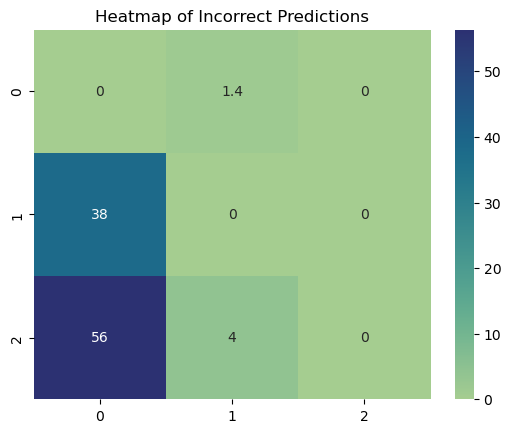

In [14]:
# 예측한 결과와 실제 정답 데이터를 비교하여 Confusion Matric  생성 후 시각화
labels = labels=["Shoe", "Sandal", "Boot"]
cm = confusion_matrix(Y_test_labels, Y_pred_labels, labels=labels, normalize='true') * 100

CM = pd.DataFrame(cm,
                  columns = [label+'_pred' for label in labels],
                  index = [label+'_true' for label in labels]).copy()

np.fill_diagonal(cm, 0)
cm = cm *100 / cm.sum()
sns.heatmap(cm, annot=True, cmap="crest")
plt.title('Heatmap of Incorrect Predictions')

CM

In [15]:
# 모델의 예측값과 실제값을 비교하여 예측이 틀린 데이터를 찾아냄
prediction_df = pd.DataFrame(zip(Y_pred_labels[:,0], Y_test_labels[:,0]), columns=['Pred', 'True'])
prediction_df['Correct'] = prediction_df['Pred'] == prediction_df['True']
incorrect_predictions = list(prediction_df[prediction_df['Correct'] == False].index)

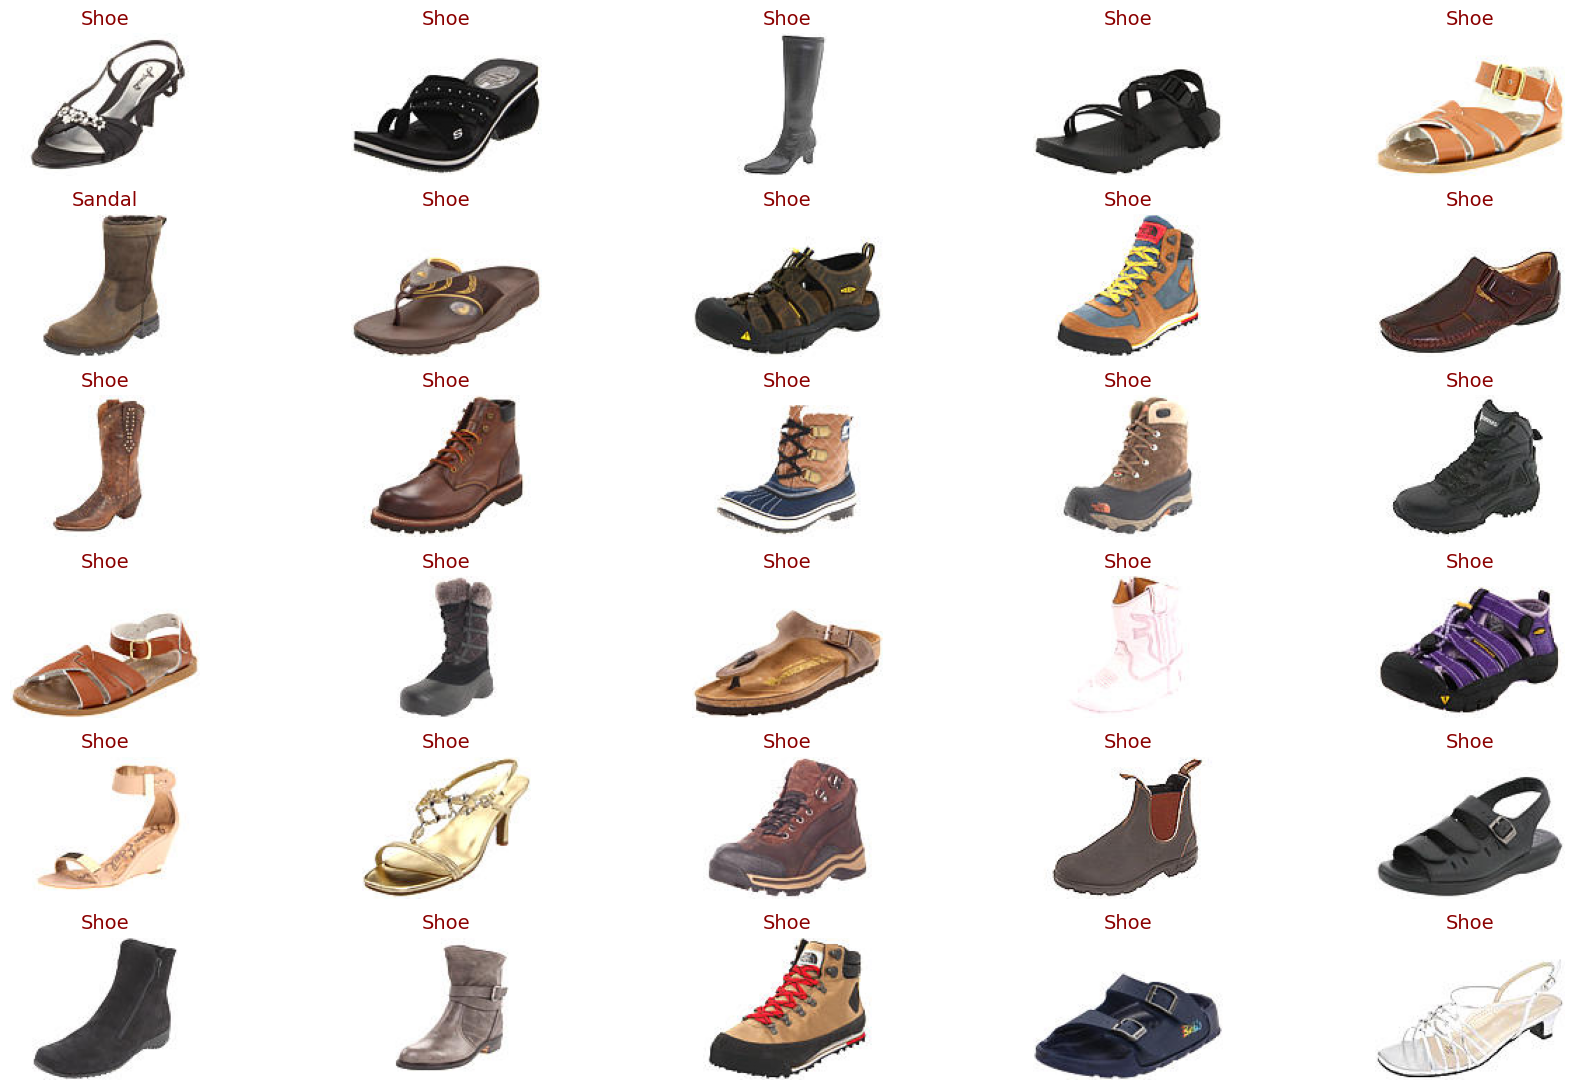

In [16]:
# 예측이 빗나간 데이터 시각화
fig, axs = plt.subplots(6,5, figsize=[18,11])
for i, inpred in enumerate(incorrect_predictions[:30]):
    ax = axs[i//5, i%5]
    ax.imshow(X_test[inpred])
    ax.axis('off')
    ax.set_title(Y_pred_labels[inpred][0], fontsize=14, color="darkred")
    
fig.tight_layout()
fig.show()